In [1]:
from google.colab import files
uploaded1 = files.upload()

Saving lap3.csv to lap3.csv


In [2]:
uploaded2 = files.upload()

Saving lap4.csv to lap4.csv


In [3]:
uploaded3 = files.upload()

Saving lap4l.csv to lap4l.csv


In [59]:
from tensorflow import keras
from keras.layers import Bidirectional
import io
import time
from keras.layers import LSTM,GRU
from keras.models import Sequential
from keras.layers import Dense
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
import matplotlib.pyplot as plt
data1 = pd.read_csv(io.BytesIO(uploaded1['lap3.csv']))
data2=pd.read_csv(io.BytesIO(uploaded3['lap4l.csv']))
data3=pd.read_csv(io.BytesIO(uploaded2['lap4.csv']))
v2vd=pd.concat([data1,data2,data3],ignore_index=True)

In [60]:
binary_mapping = {'N': 0 ,'Y': 1}
v2vd[' Packet Received (Y/N)'] = v2vd[' Packet Received (Y/N)'].map(binary_mapping)
v2vd=pd.DataFrame(v2vd.loc[50000:64000,:])

In [61]:

# Define the number of previous time steps to consider for prediction
lookback =15

# Select the desired features and convert them to numpy arrays
selected_features = [' Packet Received (Y/N)','Time in Sec', ' Receiver Speed', ' Sender Speed(km/h)']
dataset =v2vd[selected_features].values
# Scale the dataset between 0 and 1
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_dataset = scaler.fit_transform(dataset)
# Create the input and output datasets
X, y = [], []
for i in range(lookback, len(scaled_dataset)):
    X.append(scaled_dataset[i - lookback:i])
    y.append(scaled_dataset[i])

X = np.array(X)
y = np.array(y)

# Split the dataset into training and testing sets
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]
Adam=keras.optimizers.Adam(learning_rate=0.005)
# Build the LSTM model
model = Sequential()
model.add(Bidirectional(LSTM(units=60, return_sequences=True, input_shape=(lookback, len(selected_features)))))
model.add(Bidirectional(LSTM(units=60)))
model.add(Dense(units=len(selected_features)))
from keras import metrics
m = keras.metrics.RootMeanSquaredError()
metrics1=[metrics.mae,metrics.mse,m]
# Compile and train the model
model.compile(optimizer='adam', loss='mean_squared_error',metrics=metrics1)


In [62]:
start = time.time()
history=model.fit(X_train, y_train, epochs=120, batch_size=32)
end = time.time()
total_time_lstm = end - start
print("Time for fitting lstm:   "+ str(total_time_lstm))

Epoch 1/120
350/350 [==============================] - 21s 32ms/step - loss: 0.0090 - mean_absolute_error: 0.0321 - mean_squared_error: 0.0090 - root_mean_squared_error: 0.0950
Epoch 2/120
350/350 [==============================] - 11s 31ms/step - loss: 0.0015 - mean_absolute_error: 0.0107 - mean_squared_error: 0.0015 - root_mean_squared_error: 0.0391
Epoch 3/120
350/350 [==============================] - 13s 37ms/step - loss: 0.0015 - mean_absolute_error: 0.0101 - mean_squared_error: 0.0015 - root_mean_squared_error: 0.0382
Epoch 4/120
350/350 [==============================] - 11s 31ms/step - loss: 0.0015 - mean_absolute_error: 0.0110 - mean_squared_error: 0.0015 - root_mean_squared_error: 0.0382
Epoch 5/120
350/350 [==============================] - 10s 28ms/step - loss: 0.0014 - mean_absolute_error: 0.0103 - mean_squared_error: 0.0014 - root_mean_squared_error: 0.0373
Epoch 6/120
350/350 [==============================] - 11s 31ms/step - loss: 0.0014 - mean_absolute_error: 0.0107 -

In [46]:
train_loss = model.evaluate(X_train, y_train)
test_loss = model.evaluate(X_test, y_test)
print(f'Train Loss: {train_loss:}')
print(f'Test Loss: {test_loss:}')
# Make predictions on the test set
predictions = model.predict(X_test)
# Inverse scale the predictions and actual values
predictions = scaler.inverse_transform(predictions)
y_test = scaler.inverse_transform(y_test)

88/88 [==============================] - 1s 6ms/step - loss: 1.3267e-04 - mean_absolute_error: 0.0080 - mean_squared_error: 1.3267e-04 - root_mean_squared_error: 0.0115
Train Loss: [0.0008090263581834733, 0.005790610332041979, 0.0008090263581834733, 0.028443390503525734]
Test Loss: [0.00013267388567328453, 0.008003673516213894, 0.00013267388567328453, 0.011518415063619614]
88/88 [==============================] - 1s 6ms/step


In [50]:
p_target=[]
for j  in range(len(predictions)):
    p_target.append(predictions[j][3])
target=[]
for j  in range(len(y_test)):
    target.append(y_test[j][3])

Text(0.5, 1.0, 'MAE for BiLSTM')

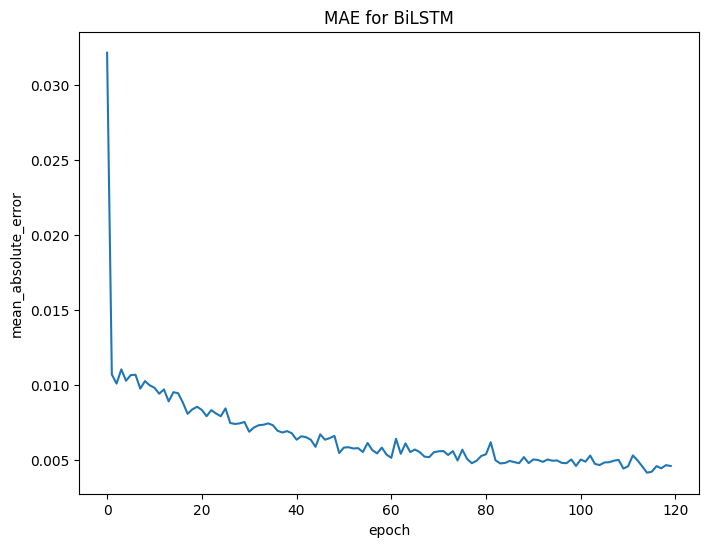

In [66]:
import matplotlib.pyplot as plt
fig , ax =plt.subplots(figsize=(8,6))
ax.plot(history.history['mean_absolute_error'],label='mean_absolute_error')
plt.xlabel('epoch')
plt.ylabel('mean_absolute_error')
plt.title('MAE for BiLSTM')

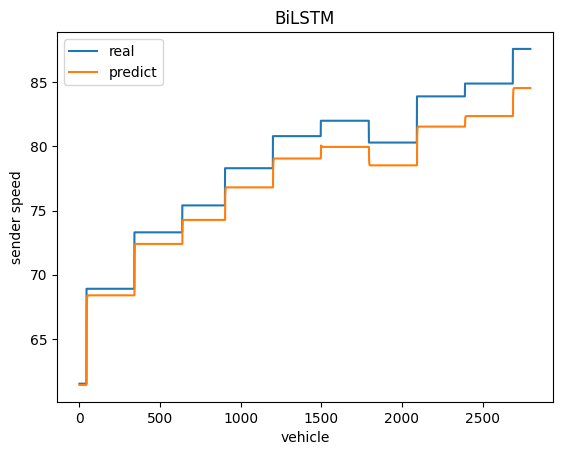

In [52]:
import matplotlib.pyplot as plt
def prediction_plot(p_target):
    fig, ax = plt.subplots()
    ax.plot(np.arange(len(target)),target, label="Real")
    ax.plot(np.arange(len(target)),p_target, label="Prediction")
    ax.legend(['real','predict'])
    plt.xlabel('vehicle')
    plt.title('BiLSTM')
    plt.ylabel('sender speed')
prediction_plot(p_target)